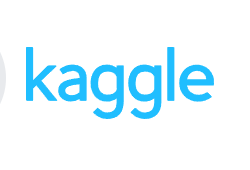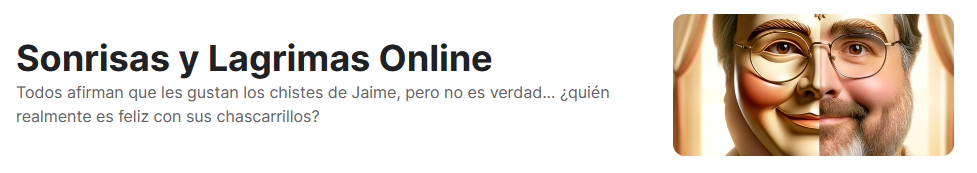

# MODELO USADO

### MODELO DENSENET201( DENSE CONVOLUTIONAL NETWORK)<br>
    - Creadores: Gao Huang, Zhuang Liu y Kaming He en 2014
    - Su arquitectura es de CNN profunda siendo  muy efeciente en el aprendizaje y en su capacidad de reducir el problema de la desaparicion de gradientes.
    -  Se compone de 201 capas convolucionales, habiendo isdo pre-entrenado con un conjunto de dfatos de ImageNet, caracterizandose por:
        - Las conexiones de cada capa densa con las anteriores, permitiendo  una mejor reutilizacion de su caracteristcas. 
        - El numero de canales de salida va aumentando gradiualmente a lo largo de toda la red, permitiendo una mayor representacion, es decir un una mejor trasnformación de los datos de entrada en la red, aprediendo patrotes y extrayendo caracteristicas de la misma.
        - La red se compone de bloques de capas que contienen varias capas convoluciones, siendo ideales para imagenes y objetos.
        - Usa una funcion de crecimiento para determinar el nuemro de canales de salida de cada bloque.
 


importanciones

In [2]:
import tensorflow as tf
import os
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#habilita la aceleracion por hardware de mi grafica
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla=true"

Num GPUs Available:  1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,ReduceLROnPlateau,CallbackList
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from PIL import Image


# Ruta al archivo 
file_path_train= r"D:\Cursos\REPOSITORIOS\ONLINE_DS_THEBRIDGE_V\COMP_SONRISAS_LAGRIMAS"

# Directorio de las imágenes train
dir_train = r"D:\Cursos\REPOSITORIOS\ONLINE_DS_THEBRIDGE_V\COMP_SONRISAS_LAGRIMAS\data_sonrisa\train"
dir_test = r"D:\Cursos\REPOSITORIOS\ONLINE_DS_THEBRIDGE_V\COMP_SONRISAS_LAGRIMAS\data_sonrisa\test\images"

MEJOR 0.9464 EN KAGGLE

In [5]:
test=pd.read_csv(os.path.join(file_path_train,"test_set.csv"))
test.drop(columns=["Unnamed: 0"], inplace=True)
test.drop(columns=["paths"], inplace=True)

In [4]:
# Crear un generador de imágenes, que aumenta las imágenes de entrenamiento girando, desplazando y volteando las mismas
train_datagen = ImageDataGenerator(
    rescale=1./255, # LAS ESCALO PARA QUE ESTEN ENTRE 0 Y 1
    validation_split=0.2, 
    rotation_range=20, # RANGO DE ROTACIÓN
    width_shift_range=0.2, # RANGO DE DESPLAZAMIENTO HORIZONTAL
    height_shift_range=0.2, # RANGO DE DESPLAZAMIENTO VERTICAL
    horizontal_flip=True,    # VOLTEO HORIZONTAL
    vertical_flip=True,   # VOLTEO VERTICAL
    shear_range=0.2,  # Parámetro de inclinación de las imágenes
    zoom_range=0.2, # RANGO DE ZOOM
    fill_mode='nearest',# MODO DE RELLENO DE LOS PÍXELES
    brightness_range=[0.2, 1.0], # RANGO DE BRILLO DE LAS IMÁGENES
    channel_shift_range=0.2 # RANGO DE CAMBIO DE CANAL de color de las imágenes
)

#creo un conjunto de train y  validacion de las imagnes del train
train_generator = train_datagen.flow_from_directory('data_sonrisa/train', target_size=(48, 48), batch_size=32, class_mode='binary', subset='training')
validation_generator = train_datagen.flow_from_directory('data_sonrisa/train', target_size=(48, 48), batch_size=32, class_mode='binary', subset='validation')

Found 9683 images belonging to 2 classes.
Found 2419 images belonging to 2 classes.


optimizador= Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam', clipvalue=0.3, clipnorm=1.0, decay=0.001) MEJOR LR

In [7]:
test=pd.read_csv(os.path.join(file_path_train,"test_set.csv"))

test.drop(columns=["Unnamed: 0"], inplace=True)

test.drop(columns=["paths"], inplace=True)

In [9]:
modelo_sonrisas_jaime= load_model (r'D:\Cursos\REPOSITORIOS\SONRISAS Y LAGRAMAS\modelos\modelo_densenet201_13.h5')

test_dir= os.path.join(file_path_train, "data_sonrisa/test/images")

test_id_img = test['id_img'].values
test_label = validation_generator.classes

# Crear una lista vacía para almacenar las imágenes
test_images = []

  # Iterar sobre todos los nombres de los archivos de  als imagenes
for filename in test_id_img:
    # Cargar la imagen
    img = Image.open(os.path.join(test_dir, str(filename) + '.jpg')) 
    # Convertir la imagen a un array de numpy y normalizarla
    img = np.array(img) / 255.0
    # Añadir la imagen a la lista de imágenes
    test_images.append(img)

# Convertir la lista de imágenes en un array de numpy
test_images = np.array(test_images)

# Convertir lala lista de imágenes de escala de grises a RGB con 3 dimensiones en el eje -1
test_images_rgb = np.stack([test_images]*3, axis=-1)

# Hacer predicciones con el modelo
y_pred = modelo_sonrisas_jaime.predict(test_images_rgb)
y_pred = (y_pred > 0.5).astype(int)

y_pred=y_pred[:len(test_label)]

# Calcular la precisión y el recall
recall = recall_score(test_label, y_pred)

print(classification_report(test_label, y_pred))

93/93 [==============================] - 6s 33ms/step
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1432
           1       0.85      0.60      0.70       987

    accuracy                           0.79      2419
   macro avg       0.81      0.76      0.77      2419
weighted avg       0.80      0.79      0.78      2419



In [31]:
"""
df_test=pd.DataFrame({'label': y_pred.flatten()})

predicciones=pd.concat([test, df_test], axis=1)

predicciones["label"]= predicciones["label"].apply(lambda x: "happy" if x==0 else "sadness")

predicciones.to_csv(r"D:\Cursos\REPOSITORIOS\ONLINE_DS_THEBRIDGE_V\COMP_SONRISAS_LAGRIMAS\predicciones\__prediccion_densenet201_mejor.csv", index=False)"""

'\ndf_test=pd.DataFrame({\'label\': y_pred.flatten()})\n\npredicciones=pd.concat([test, df_test], axis=1)\n\npredicciones["label"]= predicciones["label"].apply(lambda x: "happy" if x==0 else "sadness")\n\npredicciones.to_csv(r"D:\\Cursos\\REPOSITORIOS\\ONLINE_DS_THEBRIDGE_V\\COMP_SONRISAS_LAGRIMAS\\predicciones\\__prediccion_densenet201_mejor.csv", index=False)'

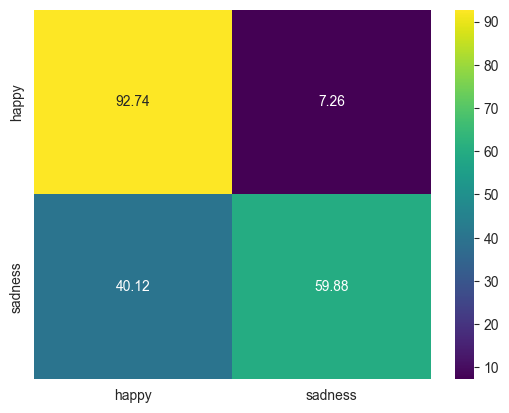

In [30]:
cm=confusion_matrix(test_label, y_pred)
cm_porcentaje= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
sns.heatmap(cm_porcentaje, annot=True, fmt= '.2f', cmap="viridis", xticklabels=["happy", "sadness"], yticklabels=["happy", "sadness"])
plt.show;

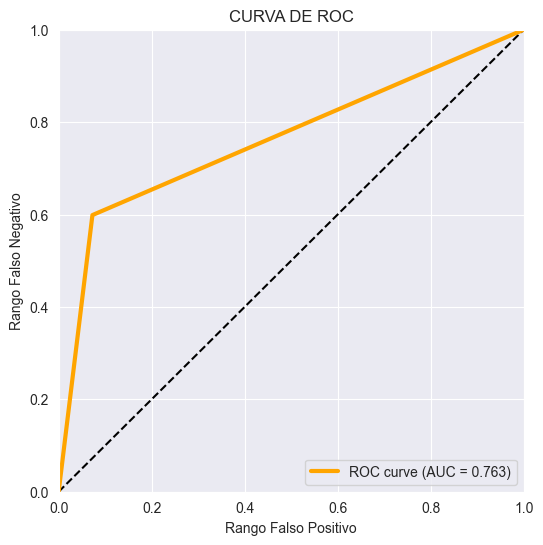

In [28]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Rango Falso Positivo')
plt.ylabel('Rango Falso Negativo')
plt.title('CURVA DE ROC')
fpr, tpr, _ = roc_curve(test_label, y_pred)
roc_auc = auc(fpr, tpr)
lw =3
plt.plot(fpr, tpr, lw=lw, color="orange" ,label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.legend(loc='lower right')
plt.show()

La curva de Roc representa que es un modelo significavamente mejor que cualquer modelo aleatorio(0.5, demostrando que tiene cierta capacidad de discriminar entre las fotografias, pero muy alejado de la perfeccion (1))